<a href="https://colab.research.google.com/github/daudkresna/ALL_VGG-16/blob/main/ALL_VGG-16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.models import Sequential
from keras import optimizers
import time
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import seaborn as sns
import collections

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import glob
import numpy as np
from tensorflow import keras
import tensorflow.keras.backend as K
import cv2

# Pemanggilan Dataset

In [ ]:
PARENT_PATH = '/content/drive/MyDrive/learning_code/transfer-learning-keras/ALL_IDB/New_Model' # path penyimpanan evaluasi
PATH = '/content/drive/MyDrive/learning_code/transfer-learning-keras/ALL_IDB/ALL_IDB2' # path data
BATCH_SIZE = 32 # definisi ukuran batch_size

# membaca file dalam path data
dataset_all = glob.glob(PATH + '/all/*.tif')
dataset_hem = glob.glob(PATH + '/normal/*.tif')
print('Jumlah data citra ALL : %s' % len(dataset_all))
print('Jumlah data citra Normal : %s' % len(dataset_hem))

imgs_list = [f for f in (dataset_all+dataset_hem)] # menggabungkan data all dan data normal
N = len(imgs_list)
print("Jumlah data citra :",N)

Jumlah data citra ALL : 130
Jumlah data citra Normal : 130
Jumlah data citra : 260


In [ ]:
# if K.image_data_format() == 'channel_first': # melihat shape citra
#     input_shape = (3, image_size[0], image_size[1])
# else:
#     input_shape = (image_size[0], image_size[1], 3)
# print(input_shape) # menampilkan ukuran shape citra

# Preprocessing

In [ ]:
image_size = (224,224) # ukuran citra


img_rgb = np.zeros((N,image_size[0], image_size[1], 3))
y = np.zeros((N,))

for i,img_path in enumerate(imgs_list):
    img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB) # konversi gambar bgr ke rgb
    img_resized = cv2.resize(img, image_size)

    # RGB images
    img_rgb[i,:,:,:] = img_resized/255

    idx = img_path.find(".tif") #index ke menuju .tif
    y[i] = int(img_path[idx-1])


# Pembagian Dataset Train dan Test

In [ ]:
from sklearn.model_selection import train_test_split
# split data train dan test
idXtr, idXte, y_train, y_test = train_test_split(range(260), y, test_size=0.2, shuffle=True, stratify=y)
X_train = img_rgb[idXtr]
X_test = img_rgb[idXte]


In [ ]:
import collections
#count 0 in y_test
print(np.count_nonzero(y_test == 0))
counter = collections.Counter(y_train)
counter

26


Counter({0.0: 104, 1.0: 104})

# Augmentasi Data

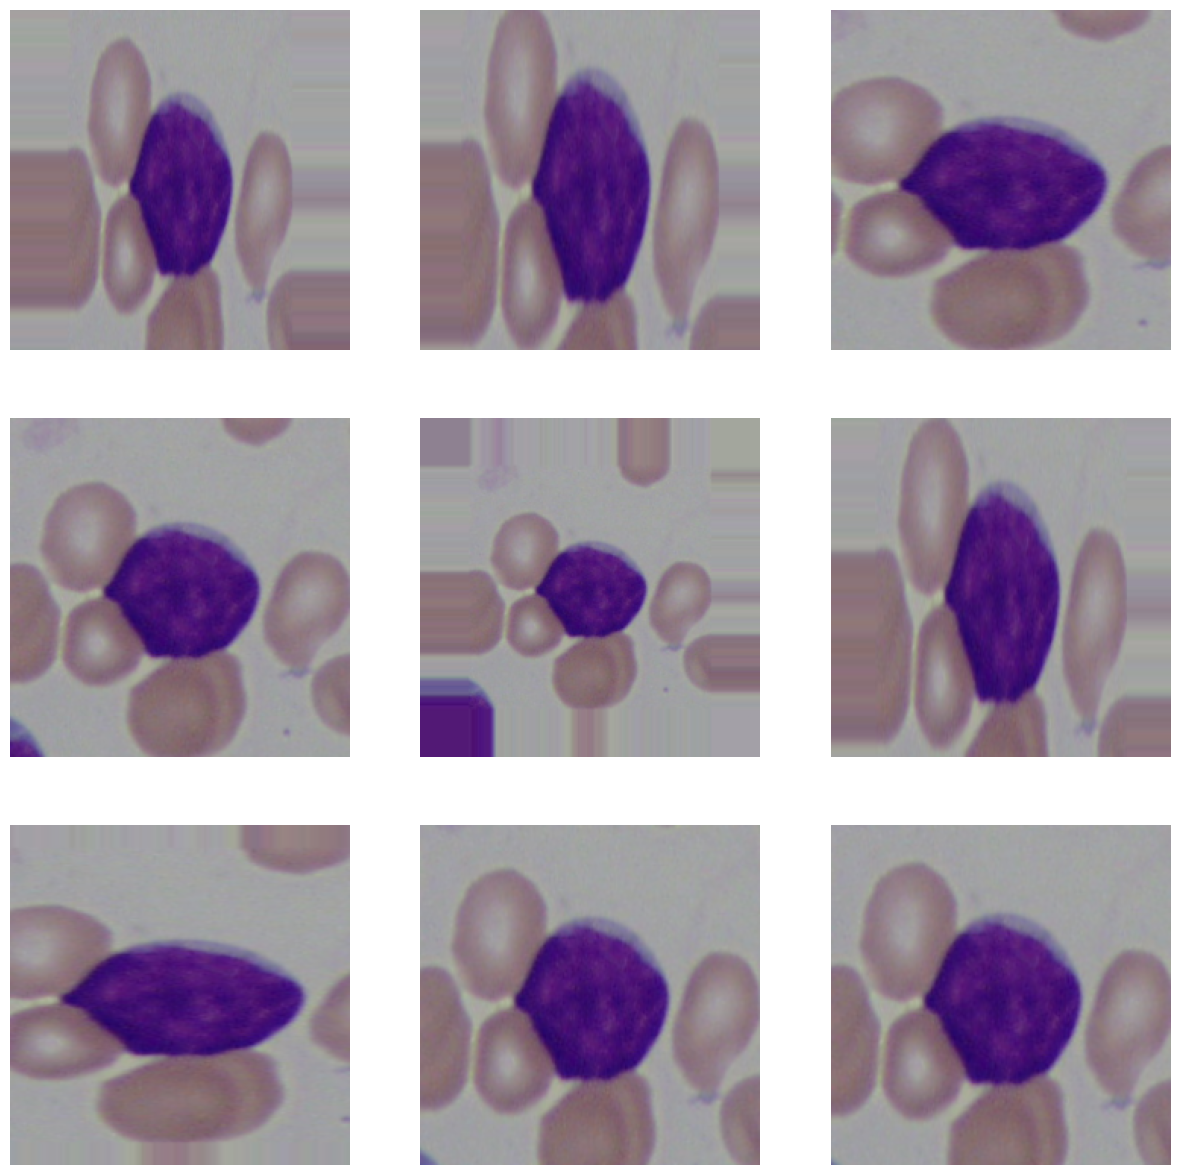

In [ ]:
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from keras import backend as K
K.clear_session()

datagen = ImageDataGenerator( # augmentasi data dengan ImageDataGenerator
    horizontal_flip=True, # augmentasi dengan horizontal flip
    vertical_flip=True, # augmentasi dengan vertical flip
    rotation_range=45, # augmentasi dengan rotasi
    fill_mode='nearest', # augmentasi dengan fill mode
    )

# datagenOri = ImageDataGenerator()

datagen.fit(X_train) # fitting augmentasi
aug = datagen.flow(X_train[0:1], y_train[0:1], batch_size = BATCH_SIZE)
batch = aug.next()

# melihat hasil augmentasi citra
# generate samples dan plot
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(15,15))

hasil_x = [aug.next()[0] for i in range(BATCH_SIZE)]
hasil_x = np.concatenate(hasil_x)
hasil_y = [aug.next()[1] for i in range(BATCH_SIZE)]
hasil_y = np.concatenate(hasil_y)

id = 0
# generate batch dari images
for row in ax:
  for col in row:

    #image = aug.next()[0]
    col.imshow(hasil_x[id])
    col.axis('off')
    id += 1
fig.savefig('full_figure.png', bbox_inches='tight')

# for i, axes in enumerate(ax):
#   #aug only the first image in the batch
#   #image = aug[0][0]
#   image = next(aug)[0]
#   # plot image
#   axes[i].imshow(image[i, :, :, :])
#   axes[i].axis('off')




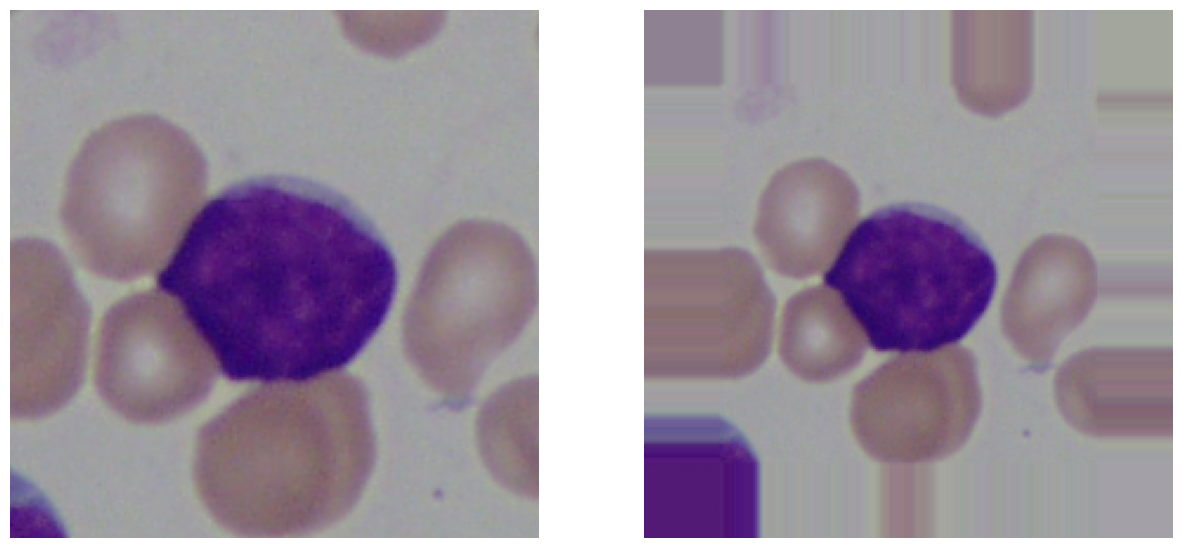

In [ ]:
# melihat hasil augmentasi citra
# generate samples dan plot
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,15))

# generate batch dari images
ax[0].imshow(X_train[0, :, :, :])
ax[0].axis('off')
ax[1].imshow(hasil_x[4, :, :, :])
ax[1].axis('off')

# for i, axes in enumerate(ax):
#   #aug only the first image in the batch
#   #image = aug[0][0]
#   image = next(aug)[0]
#   # plot image
#   axes[i].imshow(image[i, :, :, :])
#   axes[i].axis('off')

fig.savefig('contoh aug.png', bbox_inches='tight')



In [ ]:
model = keras.models.load_model(PARENT_PATH + '/Model/model_ori_vgg16_1_0.001_100.h5')

In [ ]:
import collections
#count 0 in y_test
counter = collections.Counter(y_test)
print(counter)

Counter({0.0: 828, 1.0: 815})

In [ ]:
K.clear_session()

In [ ]:
IMAGE_SIZE = [224,224]
vgg = VGG16(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)
for layer in vgg.layers:
    layer.trainable = False
def model_vgg16(learning_rate,IMAGE_SIZE):
    # model = Model(inputs=vgg.input, outputs=prediction)
    model = Sequential()
    model.add(vgg)
    model.add(Flatten())
    model.add(Dense(4096, activation='relu'))
    model.add(Dense(4096, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.summary()
    sgd = optimizers.SGD(learning_rate)
    model.compile(loss='binary_crossentropy',optimizer=sgd,metrics=['accuracy'])
    return model

58889256/58889256 [==============================] - 0s 0us/step


In [ ]:
# History training model
def plot_metrics(history, folds, LR, EPOCH):
    metric_list = [m for m in list(history.keys()) if m is not 'lr']
    size = len(metric_list)//2
    fig, axes = plt.subplots(size, 1, sharex='col', figsize=(20, size * 4))
    if size > 1:
        axes = axes.flatten()
    else:
        axes = [axes]

    for index in range(len(metric_list)//2):
        metric_name = metric_list[index]
        val_metric_name = metric_list[index+size]
        axes[index].plot(history[metric_name], label='Train %s' % metric_name)
        axes[index].plot(history[val_metric_name], label='Validation %s' % metric_name)
        axes[index].legend(loc='best', fontsize=16)
        axes[index].set_title(metric_name)
        if 'loss' in metric_name:
            axes[index].axvline(np.argmin(history[metric_name]), linestyle='dashed')
            axes[index].axvline(np.argmin(history[val_metric_name]), linestyle='dashed', color='orange')
        else:
            axes[index].axvline(np.argmax(history[metric_name]), linestyle='dashed')
            axes[index].axvline(np.argmax(history[val_metric_name]), linestyle='dashed', color='orange')

    plt.xlabel('Epochs', fontsize=16)
    sns.despine()
    plt.savefig(PARENT_PATH + '/M_Performance/model_ori_vgg16_%s_%s_%s.png' % (folds, LR, EPOCH), bbox_inches='tight')
    plt.show()



<>:3: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:3: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<ipython-input-22-4f52ad56074f>:3: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  metric_list = [m for m in list(history.keys()) if m is not 'lr']


In [ ]:
def evaluasi(model, folds, LR, EPOCH):
    y_pred = model.predict(X_test)
    y_pred = (y_pred >= 0.5).astype(int)

    print('### Confusion Matrix')
    cm = confusion_matrix(y_test,y_pred)
    cm_df = pd.DataFrame(cm, ['Normal', 'ALL'], columns=['Normal', 'ALL'])

    plt.figure(figsize=(5,4))

    # Input parameter dengan dataframe yg sudah dibuat
    sns.heatmap(cm_df, annot=True)
    plt.title('Confusion Matrix')
    plt.ylabel('Nilai Aktual')
    plt.xlabel('Nilai Prediksi')
    # Menampilkan plot
    plt.savefig(PARENT_PATH + '/Confusion_Matrix/model_ori_vgg16_%s_%s_%s.png' % (folds, LR, EPOCH), bbox_inches='tight')
    plt.show()



    print("Accuracy %2.4f" % accuracy_score(y_test, y_pred))
    print('Precision: %2.4f' % precision_score(y_test, y_pred))
    print('Recall: %2.4f' % recall_score(y_test, y_pred))
    print('F1 Score: %2.4f' % f1_score(y_test, y_pred))


In [ ]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
def kurva_roc(LR, EPOCH):
  plt.figure(figsize=(5,5))
  plt.plot([0, 1], [0, 1], 'k--')
  for i in range(1, 6):
    model = keras.models.load_model(PARENT_PATH + '/Model/model_ori_vgg16_%s_%s_%s.h5' % (i, LR, EPOCH))
    fold_metrics[i] = {}
    fold_metrics[i]['y_pred'] = model.predict(X_test).ravel()
    fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, fold_metrics[i]['y_pred'])
    fold_metrics[i]['fpr'] = fpr_keras
    fold_metrics[i]['tpr'] = tpr_keras
    fold_metrics[i]['thresholds'] = thresholds_keras
    fold_metrics[i]['auc'] = auc(fold_metrics[i]['fpr'], fold_metrics[i]['tpr'])
    plt.plot(fold_metrics[i]['fpr'], fold_metrics[i]['tpr'], label='Fold-%s (area = {:.3f})'.format(fold_metrics[i]['auc']) % i)
  plt.xlabel('False positive rate')
  plt.ylabel('True positive rate')
  plt.title('ROC curve')
  plt.legend(loc='best')
  #plt.savefig(PARENT_PATH + '/ROC/model_ori_vgg16_%s.png' % LR, bbox_inches='tight')
  plt.show()

In [ ]:
import time
from datetime import datetime
from sklearn.model_selection import StratifiedKFold

LR = 0.01
EPOCH = 100


kfold = StratifiedKFold(n_splits=5, shuffle=True)

folds = 0

for train, val in kfold.split(range(len(y_train)), y_train):
    folds += 1
    print("\nTraining model Fold-%s" % folds)

    X_train_fold = X_train[train]
    X_val = X_train[val]
    y_train_fold = y_train[train]
    y_val = y_train[val]
    model = model_vgg16(LR,IMAGE_SIZE)
    start = datetime.now()
    history = model.fit(datagen.flow(X_train_fold, y_train_fold, batch_size=BATCH_SIZE), steps_per_epoch = len(X_train_fold) // BATCH_SIZE, epochs = EPOCH, validation_data = (X_val, y_val)).history



    elapsed = time.time() - start

    print("###########################################")
    plot_metrics(history,folds,LR, EPOCH) # grafik pelatihan
    print("\n--- Model dengan fungsi optimasi SGD %s Epoch %s---\n" % (LR, EPOCH))
    print(f"### Waktu Pelatihan = {elapsed:.2f}")
    print(f"### Accuracy = {np.max(history['accuracy']):.4f}")
    print(f"### Loss = {np.min(history['loss']):.4f}\n")

    # Pengujian model
    accu = model.evaluate(X_test,y_test)

    print("\n### Loss %2.4f" % accu[0])
    print("### Akurasi %2.4f \n" % accu[1])

    evaluasi(model,folds,LR, EPOCH)
    model.save(PARENT_PATH + '/Model/model_ori_vgg16_%s_%s_%s.h5' % (folds, LR, EPOCH))
kurva_roc(LR, EPOCH)
